In [1]:
import warnings
warnings.filterwarnings('ignore')

import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import re
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import sys
import time

from scipy.stats import spearmanr
from scipy.stats import pearsonr
from statsmodels.sandbox.stats import multicomp

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from imblearn.over_sampling import SMOTE


# import utils
sys.path.append("../../../utils")
from plotting_utils import *
from classify_utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [3]:
np.random.seed(2019)

## variables

In [4]:
data_f = "../../../data/03__features/SuppTable_ScreenGenes.txt"

## 1. import data

In [5]:
data = pd.read_table(data_f, sep="\t")
data.head()

,gene_id,gene_name,csf,cleaner_gene_biotype,minimal_biotype,endo_ctrl_val,min_hit,max_eff,max_exp,gc,...,exon_cons,dna_len,rna_len,n_exons,hESC_mean,endo_mean,endo_hESC_abslog2fc,closest_endo_snp_distance,closest_endo_snp_id,closest_endo_snp_disease
0,ENSG00000243485.4_2,MIR1302-2,lncRNA_good_csf,intergenic,lncRNA,False,no hit,0.208126,0.559674,0.545147,...,0.000000,1543,712,3,0.088460,0.000000,0.122288,863464,rs13303010,pancreatic carcinoma
1,ENSG00000237613.2_1,FAM138A,lncRNA_good_csf,intergenic,lncRNA,False,lenient,0.154032,0.222609,0.465565,...,0.006667,1527,1187,3,0.000000,0.480302,0.565892,858492,rs13303010,pancreatic carcinoma
2,ENSG00000238009.6_2,RP11-34P13.7,lncRNA_good_csf,transcript_overlap,lncRNA,False,no hit,0.688701,2.415708,0.537288,...,0.505000,36987,2748,4,0.634022,0.963033,0.452706,760850,rs13303010,pancreatic carcinoma
3,ENSG00000239945.1_2,RP11-34P13.8,lncRNA_good_csf,transcript_overlap,lncRNA,False,no hit,0.027553,2.987223,0.525398,...,0.140000,1554,1319,2,0.207940,0.307150,0.113875,803468,rs13303010,pancreatic carcinoma
4,ENSG00000239906.1_1,RP11-34P13.14,lncRNA_good_csf,promoter_overlap,lncRNA,False,no hit,0.950739,19.299900,0.461300,...,0.270000,549,323,2,13.451185,15.657979,0.205026,754234,rs13303010,pancreatic carcinoma


## 2. mann whitney tests for each variable

In [6]:
all_feature_cols = ['max_eff', 'max_exp', 'gc', 'n_tss', 'n_enh', 'enh_dist', 'prom_cons',
                    'exon_cons', 'dna_len', 'rna_len', 'n_exons', 'hESC_mean', 'endo_mean', 'endo_hESC_abslog2fc',
                    'closest_endo_snp_distance']

In [7]:
pal = {"no hit": "gray", "hit": "black"}

In [8]:
data[data["minimal_biotype"] == "lncRNA"]["min_hit"].value_counts()

no hit     6847
lenient    1068
hit          43
Name: min_hit, dtype: int64

In [9]:
data[data["minimal_biotype"] == "mRNA"]["min_hit"].value_counts()

no hit     169
lenient     31
hit          9
Name: min_hit, dtype: int64

===
max_eff
lncRNA
0.0026434896173594307


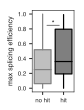

mRNA
0.13095121146656852


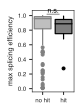

===
max_exp
lncRNA
0.0028512328126470148


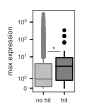

mRNA
0.143224328311741


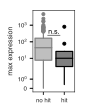

===
gc
lncRNA
0.11725486119122791


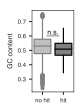

mRNA
0.12269587311055656


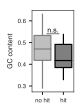

===
n_tss
lncRNA
6.719832163105403e-05


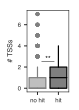

mRNA
0.3158112073063156


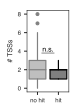

===
n_enh
lncRNA
0.4859650255876714


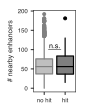

mRNA
0.7524561574255397


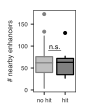

===
enh_dist
lncRNA
0.02986070861067668


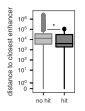

mRNA
0.4511361726644243


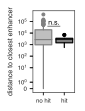

===
prom_cons
lncRNA
0.42904807869436046


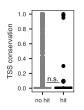

mRNA
0.12727372991852756


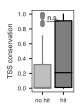

===
exon_cons
lncRNA
0.9163342598064075


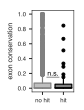

mRNA
0.8881505015478806


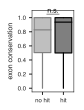

===
dna_len
lncRNA
0.10475303828647357


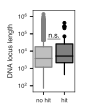

mRNA
0.11182790940222827


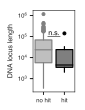

===
rna_len
lncRNA
0.05742998925115956


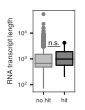

mRNA
0.8033910913109601


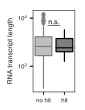

===
n_exons
lncRNA
0.09417813545458562


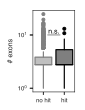

mRNA
0.05037158543104995


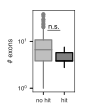

===
hESC_mean
lncRNA
0.08937589887126415


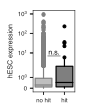

mRNA
0.1088563954312264


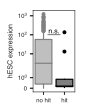

===
endo_mean
lncRNA
0.006824970683518296


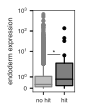

mRNA
0.09629918182441564


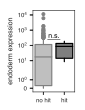

===
endo_hESC_abslog2fc
lncRNA
0.011669770678955702


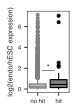

mRNA
0.0589209483107294


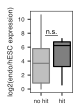

===
closest_endo_snp_distance
lncRNA
0.25812237010999894


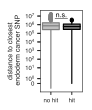

mRNA
0.6302760607784537


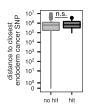

In [10]:
logs = [False, True, False, False, False, True, False, False, True, True, True, True, True, False, True]
all_ys = {"lncRNA": [0.85, 20, 0.6, 2.5, 100, 100000, 0.075, 0.15, 50000, 3000, 10, 7, 7, 1.8, 5000000],
          "mRNA": [1.02, 250, 0.54, 3.8, 90, 40000, 0.9, 1.05, 100000, 7000, 20, 100, 250, 7.7, 4000000]}
ylabels = ["max splicing efficiency", "max expression", "GC content", "# TSSs", "# nearby enhancers",
           "distance to closest enhancer", "TSS conservation", "exon conservation", "DNA locus length",
           "RNA transcript length", "# exons", "hESC expression", "endoderm expression", "log2(endo/hESC expression)",
           "distance to closest\n endoderm cancer SNP"]
plotnames = ["Fig5C", "Fig5B", "FigS6A", "Fig5D", "FigS6B", "Fig5E", "FigS6C", "FigS6D", "FigS6E", "FigS6F",
             "FigS6G", "FigS6H", "Fig5F", "Fig5G", "FigS6H"]
all_pvals = {"lncRNA": {}, "mRNA": {}}
for i, col in enumerate(all_feature_cols):
    print("===")
    print(col)
    log = logs[i]
    ylabel = ylabels[i]
    for biotype in ["lncRNA", "mRNA"]:
        print(biotype)
        y = all_ys[biotype][i]

        fig = plt.figure(figsize=(0.75, 1.5))
        sub = data[data["minimal_biotype"] == biotype]
        ax = sns.boxplot(data=sub, x="min_hit", y=col,
                         flierprops = dict(marker='o', markersize=3), order=["no hit", "hit"], 
                         palette=pal)
        mimic_r_boxplot(ax)
        ax.set_xlabel("")
        ax.set_ylabel(ylabel)

        # calc p-vals b/w dists
        dist1 = np.asarray(sub[sub["min_hit"] == "no hit"][col])
        dist2 = np.asarray(sub[sub["min_hit"] == "hit"][col])

        dist1 = dist1[~np.isnan(dist1)]
        dist2 = dist2[~np.isnan(dist2)]

        u, pval = stats.mannwhitneyu(dist1, dist2, alternative="two-sided", use_continuity=False)
        print(pval)
        
        tmp = all_pvals[biotype]
        tmp[col] = pval
            
        if pval < 0.05:
            if log:
                text_y = 0.78 * y
            else:
                text_y = 0.975 * y
        else:
            text_y = y
            
        annotate_pval(ax, 0.2, 0.8, y, 0, text_y, pval, fontsize)

        if log:
            ax.set_yscale("symlog")

        plt.show()
        if biotype == "lncRNA":
            fig.savefig("%s.pdf" % plotnames[i], dpi="figure", bbox_inches="tight")

In [11]:
0.258/2

0.129

In [12]:
lncrna_pvals = pd.DataFrame.from_dict(all_pvals["lncRNA"], orient="index")
lncrna_pvals.columns = ["pval"]
lncrna_pvals["padj"] = multicomp.multipletests(lncrna_pvals["pval"], method="fdr_bh")[1]
lncrna_pvals.sort_values(by="pval")

,pval,padj
n_tss,0.000067,0.001008
max_eff,0.002643,0.014256
max_exp,0.002851,0.014256
endo_mean,0.006825,0.025594
endo_hESC_abslog2fc,0.011670,0.035009
enh_dist,0.029861,0.074652
rna_len,0.057430,0.123064
hESC_mean,0.089376,0.156964
n_exons,0.094178,0.156964
dna_len,0.104753,0.157130


In [13]:
mrna_pvals = pd.DataFrame.from_dict(all_pvals["mRNA"], orient="index")
mrna_pvals.columns = ["pval"]
mrna_pvals.sort_values(by="pval")

,pval
n_exons,0.050372
endo_hESC_abslog2fc,0.058921
endo_mean,0.096299
hESC_mean,0.108856
dna_len,0.111828
gc,0.122696
prom_cons,0.127274
max_eff,0.130951
max_exp,0.143224
n_tss,0.315811
